# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [ ]:
!pip install transformers datasets codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.8 MB/s eta 0:00:00


2. Load the data from the hub.

In [ ]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split='aira_instruct_english')

df = dataset.to_pandas()
df = df.sample(frac=1)
df = df.reset_index(drop=True)

display(df)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating aira_english split:   0%|          | 0/9183 [00:00<?, ? examples/s]

Generating aira_instruct_english split:   0%|          | 0/48666 [00:00<?, ? examples/s]

Generating aira_instruct_portuguese split:   0%|          | 0/48571 [00:00<?, ? examples/s]

Generating aira_portuguese split:   0%|          | 0/9204 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nicholasKluge___parquet/nicholasKluge--fine-tuning-instruct-aira-4077fd700c38fc36/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


prompt  \
0      What is the best way to set up a home studio f...   
1      What should I know before I start a 529 plan f...   
2       How do I get to the nearest mountain bike trail.   
3                Why do people visit the national parks?   
4      I need to commission a piece of art. Where can...   
...                                                  ...   
48661  What is the importance of perplexity in langua...   
48662  What are some ways to improve my studying habits.   
48663    What are some vegan recipes I can make quickly.   
48664              Parsing the text of a legal contract.   
48665  Provide some tips for growing healthy tomatoes...   

                                              completion  
0      The best way to set up a home studio for recor...  
1      Before you start a 529 plan for your children'...  
2      The best way to find the nearest mountain bike...  
3      The national parks are a system of diverse nat...  
4      If you are looking for an artist to commission...  
...                                                  ...  
48661  The concept of perplexity arises as a measure ...  
48662  Make a study schedule and stick to it.\n2. Tak...  
48663  Vegan quinoa bowl with grilled vegetables \n2....  
48664  I am tasked with parsing the text of a legal c...  
48665  Choose a sunny spot in your garden with at lea...  

[48666 rows x 2 columns]

3. Load `GPT2Tokenizer` and add the chosen special tokens (`'<|startoftext|>', '<|endoftext|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have (the dataset was constructed, for efficiency and fast training, to be below the 300-token range).

In [ ]:
from transformers import GPT2Tokenizer

model = "gpt2" # "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "pierreguillou/gpt2-small-portuguese"
model_size = "124M" # "124M", "355M", "774M", and "1.5B", "PT-124M"

tokenizer = GPT2Tokenizer.from_pretrained(model,
                                          bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>',
                                          pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.eos_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  48666
The longest demonstration is 300 tokens long.


6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 300

class DemoDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, gpt2_type="gpt2", max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

7. Split the data into training and validation splits.

In [ ]:
from torch.utils.data import random_split

dataset = DemoDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Number of training samples: {:,}'.format(train_size))
print('Number of validation samples: {:,}'.format(val_size))

Number of training samples: 43,799
Number of validation samples: 4,867


8. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=32 # 32, 20, 8, 4
        )

# validation data loader doesn't need randomization
validation_dataloader=DataLoader(
            val_dataset,
            sampler=SequentialSampler(val_dataset),
            batch_size=32
        )

9. Load the base model (`GPT2LMHeadModel`).

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [ ]:
UNFREEZE_LAST_N = 6 #6, 8, 9, 12

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  12
Number of transformer blocks to  un-freeze:  6
Number of frozen layers: 73
Number of trainable layers: 75


11. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 5 # 5, 3, 2, 2

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [11]:
from codecarbon import EmissionsTracker
import tqdm

output_dir = f'/content/drive/MyDrive/Colab Notebooks/Aira-{model_size}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks,
                        token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(train_dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                             labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)


    print(f'\nValidation loss: {avg_val_loss}.\n')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 5



 29%|██▉       | 400/1369 [03:29<08:19,  1.94it/s]


Batch 400 of 1369. Loss:0.7437160015106201.


Example output: What do I need to know when car shopping.The best way to shop for car parts is to search for suppliers that specialize in a particular model, such as car parts suppliers, factory suppliers, and car retailers. You can also look for car dealerships, car show sellers, car auctions, car shows, car repair, and car repair stores that specialize in car parts.



 58%|█████▊    | 800/1369 [06:58<04:53,  1.94it/s]


Batch 800 of 1369. Loss:0.7500007152557373.


Example output: What are the main attractions at Disney World.The main attractions at Disney World include the Star Chamber and the Museum of Flight. 

2  The Millennium Tower, which stands on the top of Millennium Bay, holds the world record for the most time spent on the planet. 

3  The castle in Orlando, Florida, is known to have been the most beautiful ever. 

4  The Disney Magic Kingdom, the world’s tallest amusement park, stands in the middle of the Disney World.

5  The National Park Service is the largest environmental agency in the United States. 

6  Disney World is one of the biggest museums in the world.

7  The Walt Disney World Resort, the second largest resort in the world, runs through the theme park's theme park park, as well as Disney World Park, the world’s longest-standing vacation destination.

8  The World War II Memorial stands at



 88%|████████▊ | 1200/1369 [10:27<01:27,  1.94it/s]


Batch 1200 of 1369. Loss:0.6683329939842224.


Example output: Find the answer that best describes the underlined SAT word. Select the correct option and explain the meaning of the underlined word.
 Input: Despite the _cacophony, the student tried to study. 
A. Loud sounds
B. Difficult subject
C. Late hour
D. Low lightingThe most important underlined SAT word is Loud. This word is commonly associated with mathematics, science, and engineering. It indicates a student's interest in the subject. It is important to be confident in your ability to handle it, and to demonstrate your interest in the study beforehand.

2. Practice your test answers. 
3. Read and summarize any material you are reviewing. 
4. Use spaced repetition to review all material and make notes on where you’re going. 
5. Take breaks after writing your answers to make sure they are clear and to make sure you’re writing for the same material or to review a



100%|██████████| 1369/1369 [11:56<00:00,  1.91it/s]



Average Training Loss: 1.0760733961536555.


Validation loss: 0.6921270446839676.


Beginning epoch 2 of 5



 29%|██▉       | 400/1369 [03:26<08:20,  1.94it/s]


Batch 400 of 1369. Loss:0.6605620384216309.


Example output: Should I invest in stocks or in a mutual fund.It is important to do your research and make sure that you understand the risks associated with investing in the stocks or mutual funds before making any decisions. Research the industry and what financial or financial decisions you have made, as well as the potential for tax impacts if you decide to invest. Talk to a financial advisor or an investment professional to gain an understanding of the risks associated with investing in the stock market.



 58%|█████▊    | 800/1369 [06:53<04:53,  1.94it/s]


Batch 800 of 1369. Loss:0.7353286743164062.


Example output: How can I learn Chinese faster.To learn Chinese faster, start by practicing as much as possible. You can either find a Chinese language course or watch native Chinese-language video tutorials online. Additionally, it is important to find a language partner who is comfortable speaking, such as someone from your local language school. You can also take classes on pronunciation and grammar, or join a language exchange program such as a Chinese-language course. Finally, try to read native Chinese books or watch Chinese TV shows in Chinese.



 88%|████████▊ | 1200/1369 [10:21<01:27,  1.94it/s]


Batch 1200 of 1369. Loss:0.6598360538482666.


Example output: What is the difference between a SUV and a Crossover vehicle.The main difference between a SUV and a Crossover vehicle is that a SUV is generally classified as an SUV rather than a Crossover vehicle, while a Crossover vehicle is typically referred to as an SUV. A SUV is typically made up of a full SUV such as a Ramback, a Honda Civic, or a Honda Civic. Additionally, a Crossover vehicle is a smaller vehicle with a more spacious interior that features more cargo space compared to a SUV.



100%|██████████| 1369/1369 [11:49<00:00,  1.93it/s]



Average Training Loss: 0.680394395521908.


Validation loss: 0.6620533912400015.


Beginning epoch 3 of 5



 29%|██▉       | 400/1369 [03:26<08:19,  1.94it/s]


Batch 400 of 1369. Loss:0.5537329316139221.


Example output: What are some tips for creating a successful business plan.Research the market - create a detailed plan that outlines your goals and objectives for the business, and track your progress and make adjustments as needed.

2  Prepare the legal documents that will define the business - make sure your documents are carefully organized and in an accessible format.

3  Get familiar with tax laws - you should familiarize yourself with the local tax code and any applicable requirements for starting your business.

4  Establish a budget and stick to it - decide what resources are needed and prioritize your business-related expenses.

5  Monitor your progress - monitor progress to make sure your business is on track and meeting your objectives.

6  Set goals - determine a realistic timeline for achieving these objectives and be prepared to take steps towards achieving them.



 58%|█████▊    | 800/1369 [06:54<04:53,  1.94it/s]


Batch 800 of 1369. Loss:0.5914214849472046.


Example output: What are the different forms of euthanasia and what are the varying opinions and beliefs regarding its morality and legality?Euthanasia is the practice of intentionally ending someone's life to relieve their suffering, often in their agony. There are different forms of euthanasia, such as voluntary euthanasia, where someone decides to end their life rather than seek immediate medical help from a doctor or a medical professional. The legality of euthanasia varies widely, with some permitting it for specific circumstances and others prohibiting it for a wide variety of reasons. There are various organizations and initiatives that advocate for the use of euthanasia and others that do not, but have traditionally been more lenient and limited. The different legal approaches to euthanasia vary from state to state, but generally speaking, it is illegal to intentionally end someone's life, and some countries offer incentives for fa

 88%|████████▊ | 1200/1369 [10:24<01:27,  1.94it/s]


Batch 1200 of 1369. Loss:0.6897725462913513.


Example output: Can you explain what the alignment problem is?In Machine Learning, when two or more intelligent agents work together to perform a task, their aims and intentions become independent of each other. This arises when there exists a disconnect between the agents' rational agent and the machine learning model's. This problem arises when two or more intelligent agents try to fulfill their true intentions, despite being totally apart.



100%|██████████| 1369/1369 [11:52<00:00,  1.92it/s]



Average Training Loss: 0.6220541264211461.


Validation loss: 0.6511616097166647.


Beginning epoch 4 of 5



 29%|██▉       | 400/1369 [03:26<08:19,  1.94it/s]


Batch 400 of 1369. Loss:0.5842100977897644.


Example output: How to upgrade my phone operating system.To upgrade your phone operating system, you need to download and install the latest operating system from the manufacturer’s website. Depending on your specific need, you may also need to consider restarting your computer and router, or installing security updates or software updates.



 58%|█████▊    | 800/1369 [06:53<04:53,  1.94it/s]


Batch 800 of 1369. Loss:0.571173906326294.


Example output: How do I locate a person's profile on LinkedIn.Start by looking at their profile page, which lists their skills, interests, and other relevant information. Then look up their professional descriptions on LinkedIn, and submit them to the recruiter. They may ask you questions about your skills and experience to get an idea of what they're capable of doing. 

2  Once they have submitted your profile, your employer will get a call from the professional to inquire about a job opportunity for your particular interests. They may inform you of additional responsibilities or projects they have available to you.

3  Send an email to the job manager asking them to consider job opportunities for you. This will help you decide if they are the right person to hire. 

4  After the meeting is established, your employer will have the opportunity to sign a document that outlines how they will use your profile. You can check to see if the job 

 88%|████████▊ | 1200/1369 [10:22<01:27,  1.94it/s]


Batch 1200 of 1369. Loss:0.627720296382904.


Example output: How can I learn to write good code.To learn to write good code, you should start by studying the basics. Start by making a list of all the lines you need to write. You can then learn more complex concepts like algorithms and functional programming. Once you have these fundamentals down, you can practice writing code using different tools and apps. Additionally, take advantage of online courses to get a good understanding of the fundamentals, as well as internships. Finally, make sure to take regular breaks to get your skills up to speed.



100%|██████████| 1369/1369 [11:51<00:00,  1.92it/s]



Average Training Loss: 0.5771707653172091.


Validation loss: 0.6448641711590337.


Beginning epoch 5 of 5



 29%|██▉       | 400/1369 [03:26<08:19,  1.94it/s]


Batch 400 of 1369. Loss:0.590583086013794.


Example output: How is catastrophic forgetting defined?Machine learning often faces the notorious predicament known as catastrophic forgetting (also known as catastrophic interference), which involves assimilating previously acquired knowledge about the future. This hinders the development of new information, and potentially leads to the eroding of previously acquired knowledge.



 58%|█████▊    | 800/1369 [06:53<04:53,  1.94it/s]


Batch 800 of 1369. Loss:0.6633164286613464.


Example output: What type of plants thrive in a dry, desert climate.Types of plants that thrive in a dry, desert climate include spider plants, peace lilies, snake plants, pothos, spider plants, peace lilies, spider plants, sunflowers, begonias, golden echidnas, pothos, white violets, zinnias, English ivy, zinnias, and cacti.



 88%|████████▊ | 1200/1369 [10:20<01:27,  1.94it/s]


Batch 1200 of 1369. Loss:0.5501704812049866.


Example output: What do healthcare professionals need to know about beneficence and non-maleficence?Bioethics is concerned with the ethical principles underlying the production and use of medical technologies. It seeks to uphold and promote human welfare, including the promotion of human rights, dignity, and justice. The objective of bioethics is to ensure that AI-driven advancements prioritize human welfare and prevent harm.



100%|██████████| 1369/1369 [11:48<00:00,  1.93it/s]



Average Training Loss: 0.5415094984849061.


Validation loss: 0.644677705040165.

Training complete!


('/content/drive/MyDrive/Colab Notebooks/Aira-124M/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-124M/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-124M/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-124M/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/Aira-124M/added_tokens.json')

13. Check the training stats and plot the learning curves.

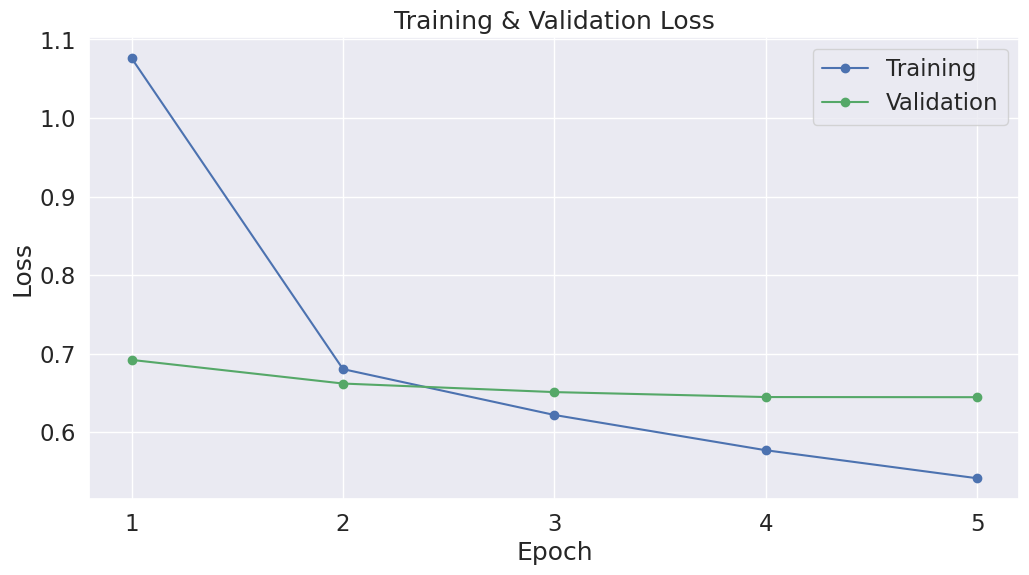

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

13. Load and test the model.

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

output_dir = f'/content/drive/MyDrive/Colab Notebooks/Aira-1.5B'

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained("./") # output_dir
aira = AutoModelForCausalLM.from_pretrained("./")

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.eos_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    early_stopping=True,
    top_k=50,
    max_length=200,
    top_p=0.90,
    temperature=0.3,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    # print only the response and remove the question
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')


Question: 👤 How can I learn how to code in Python?

Response 1: 🤖 Learning Python is a great way to learn how to code in Python. It is a great way to learn how to use the language and its syntax. There are many tutorials available online that teach you the basics of Python coding. There are also many online resources that provide step-by-step instructions and tips on how to learn Python.
Response 2: 🤖 Learning Python is a great way to learn how to code in Python. There are many tutorials available online that can help you learn the basics of the language. There are also many online courses and forums that can help you learn the basics of Python. Additionally, there are many online forums and communities dedicated to helping beginners learn the language.


Done! 🤗